In [1]:
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("seaborn-whitegrid")

In [3]:
RANDOM_SEED = 1234
SPLITS = 5

In [4]:
np.random.seed(RANDOM_SEED)

In [5]:
sst_dataset = load_dataset("hate_speech18")

Found cached dataset hate_speech18 (/home/studio-lab-user/.cache/huggingface/datasets/hate_speech18/default/0.0.0/775598e7a56b8706cb7cc3781ce7abd83f8a6d0831d6363f1c93b5f963d7c733)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
sst_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'user_id', 'subforum_id', 'num_contexts', 'label'],
        num_rows: 10944
    })
})

In [7]:
sst_dataset["train"]["text"][0:2]

['As of March 13th , 2014 , the booklet had been downloaded over 18,300 times and counting .',
 'In order to help increase the booklets downloads , it would be great if all Stormfronters who had YouTube accounts , could display the following text in the description boxes of their uploaded YouTube videos .']

In [8]:
sst = pd.DataFrame()
sst["text"] = sst_dataset["train"]["text"]
sst["label"] = sst_dataset["train"]["label"]

In [9]:
sst.drop_duplicates(inplace=True)
sst.shape

(10763, 2)

In [10]:
sst.reset_index(inplace=True)

In [11]:
sst.drop(columns="index", inplace=True)

In [12]:
sst.head(2)

,text,label
0,"As of March 13th , 2014 , the booklet had been...",0
1,In order to help increase the booklets downloa...,0


In [13]:
sst.label.value_counts(normalize=True) * 100

0    86.797361
1    11.074979
3     1.560903
2     0.566756
Name: label, dtype: float64

In [14]:
def get_dict_size(text):
    vec = TfidfVectorizer(lowercase=True, ngram_range=(1,1), analyzer="word").fit(text)
    DICT_SIZE = len(vec.get_feature_names_out())
    return DICT_SIZE

In [15]:
DICT_SIZE = get_dict_size(sst["text"])
print(DICT_SIZE)

16317


In [16]:
pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                   LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)
                  )

In [17]:
pl.fit(sst["text"], sst["label"])

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=14685)),
                ('logisticregression',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=250, random_state=1234))])

In [18]:
pl.score(sst["text"], sst["label"])

0.8504134534980953

In [19]:
cv = StratifiedKFold(n_splits=SPLITS)
cross_validate(pl, sst["text"], sst["label"], cv=cv, scoring={"accuracy", "f1_macro"})

{'fit_time': array([2.21344757, 2.24316335, 1.74875474, 2.15596485, 2.06177282]),
 'score_time': array([0.10605264, 0.09445095, 0.06044102, 0.09070492, 0.06485915]),
 'test_accuracy': array([0.7868091 , 0.75336739, 0.78077102, 0.79042751, 0.76301115]),
 'test_f1_macro': array([0.4863339 , 0.37828492, 0.43096152, 0.4288522 , 0.36281323])}

In [20]:
acc_scores = []
f1_scores = []
fold = []
lab_perc = []
i_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
t0  = time.time()
for i in i_range:
    sst["ss_label"] = np.where(sst.index.isin(sst.sample(frac=1-i).index), -1, sst.label)
    ss_pl = make_pipeline(TfidfVectorizer(max_features=int(DICT_SIZE * 0.9), lowercase=True, ngram_range=(1,1), analyzer="word"),
                          SelfTrainingClassifier(
                          LogisticRegression(C=0.5, class_weight="balanced", random_state=RANDOM_SEED, max_iter=250)))
    
    for f, (train, test), in zip(range(SPLITS), cv.split(sst["text"], sst["label"])):
        ss_pl.fit(sst["text"][train], sst["ss_label"][train])
        ss_pl_preds = ss_pl.predict(sst["text"][test])
        acc_scores.append(accuracy_score(sst["label"][test], ss_pl_preds))
        f1_scores.append(f1_score(sst["label"][test], ss_pl_preds, average="macro"))
        fold.append(f)
        lab_perc.append(i)

t1 = time.time()
exec_time = t1-t0
print(f"Execution time: {exec_time/60:.3f} minutes")

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/semi_supervised/_s

Execution time: 5.680 minutes


In [21]:
dataset_report = pd.DataFrame({"acc_scores": acc_scores,
                               "f1_scores": f1_scores,
                               "fold_number": fold,
                               "dataset_name": ["hate_speech_18_Train"] * len(acc_scores),
                               "classes": [sst["label"].nunique()] * len(acc_scores),
                               "dataset_len": [sst.shape[0]] * len(acc_scores),
                               "percent_labeled_samples": lab_perc,
                                "exec_time_secs_9_runs": [exec_time] * len(acc_scores)})

In [22]:
dataset_report

,acc_scores,f1_scores,fold_number,dataset_name,classes,dataset_len,percent_labeled_samples,exec_time_secs_9_runs
0,0.819322,0.308397,0,hate_speech_18_Train,4,10763,0.1,340.81051
1,0.823967,0.322473,1,hate_speech_18_Train,4,10763,0.1,340.81051
2,0.820251,0.311589,2,hate_speech_18_Train,4,10763,0.1,340.81051
3,0.815520,0.293944,3,hate_speech_18_Train,4,10763,0.1,340.81051
4,0.808550,0.314241,4,hate_speech_18_Train,4,10763,0.1,340.81051
5,0.815142,0.404987,0,hate_speech_18_Train,4,10763,0.2,340.81051
6,0.790060,0.334954,1,hate_speech_18_Train,4,10763,0.2,340.81051
7,0.809568,0.336274,2,hate_speech_18_Train,4,10763,0.2,340.81051
8,0.801580,0.313621,3,hate_speech_18_Train,4,10763,0.2,340.81051
9,0.782993,0.306325,4,hate_speech_18_Train,4,10763,0.2,340.81051


<AxesSubplot:xlabel='percent_labeled_samples', ylabel='acc_scores'>

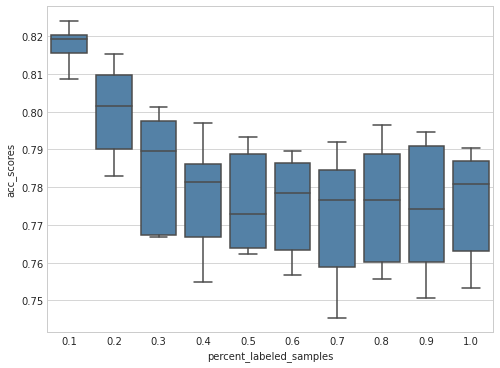

In [23]:
plt.figure(figsize=(8,6))
sns.boxplot(data=dataset_report, x="percent_labeled_samples", y="acc_scores", color="steelblue")

In [24]:
dataset_report.to_csv("hate_speech_18.csv", index=False)

In [25]:
# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
# ax[0].scatter(i_range, acc_scores)
# ax[0].plot(i_range, acc_scores)
# ax[0].set_xlabel("Percent of Labeled Samples")
# ax[0].set_ylabel("Accuracy Score")
# ax[0].set_title("% of Labeled Samples Vs Accuracy Score", fontweight="bold")
# ax[1].scatter(i_range, f1_scores)
# ax[1].plot(i_range, f1_scores)
# ax[1].set_xlabel("Percent of Labeled Samples")
# ax[1].set_ylabel("F1 Score")
# ax[1].set_title("% of Labeled Samples Vs F1 Score", fontweight="bold")
# plt.show()